In [3]:
import json
import pandas as pd
import joblib
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns

import config

In [4]:
json_result = {}

In [7]:
# model results
model_config = json.load(open(f'../{config.MODEL_CONFIG_PATH}', 'r'))
model_interpretation = joblib.load(f'../{config.MODEL_INTERPRETATION_PATH}')
model_result = pd.read_parquet(f'../{config.MODEL_RESULTS_PATH}')

employee_metadata = pd.read_csv(f'../{config.FEATURE_ENGINEERED_PATH}')
employee_metadata['execution_date'] = pd.to_datetime(employee_metadata['execution_date'])
employee_metadata = employee_metadata.sort_values(['emp_id', 'execution_date']).drop_duplicates('emp_id', keep='last') # ใช้ข้อมูลล่าสุดของพนักงานแต่ละคน
employee_metadata['model_predicted_termination'] = employee_metadata['emp_id'].map(
    model_result.set_index('emp_id')['predicted_termination']
)
employee_metadata['model_predicted_termination_probability'] = employee_metadata['emp_id'].map(
    model_result.set_index('emp_id')['termination_probability']
)
# get job level and position information
_employee_position_df = pd.read_csv(f'../{config.EMPLOYEE_POSITION_DATA}')
_employee_position_df = _employee_position_df.sort_values(by=['employee_id', 'created_at'], ascending=[True, False]).drop_duplicates(subset=['employee_id'], keep='first')
_position_df = pd.read_csv(f'../{config.POSITION_DATA}')
employee_metadata['job_level_name'] = employee_metadata['job_level'].map(config.JOB_LEVEL_MAPPER)
employee_metadata['position_id'] = employee_metadata['emp_id'].map(_employee_position_df.set_index('employee_id')['position_id'])
employee_metadata['job_title'] = employee_metadata['position_id'].map(_position_df.set_index('id')['title'])

# terminatio emp
termination_emp = employee_metadata[(employee_metadata['model_predicted_termination'] == True) | (employee_metadata['termination_value'] > 0)]

# shap
features = model_config['features']
metadata_columns = ['emp_id', 'job_title', 'job_level_name', 'department_name']

shap_df_list = []
for emp_id, shap_explanation in model_interpretation.items():
    shap_values = shap_explanation.values
    _temp_df = pd.DataFrame([shap_values], columns=features)
    _temp_df['emp_id'] = emp_id
    shap_df_list.append(_temp_df)

all_shap_df = pd.concat(shap_df_list, ignore_index=True)
shap_with_metadata = pd.merge(all_shap_df, employee_metadata[metadata_columns], on='emp_id', how='left')

#### overall summary

In [8]:
print('Overall Summary')

predicted_execution_date = employee_metadata['execution_date'].max() + relativedelta(months=1)
predicted_end_date = predicted_execution_date + relativedelta(months=3) - relativedelta(days=1)
print(f"Prediction As of {predicted_execution_date.strftime('%Y-%m-%d')} to {predicted_end_date.strftime('%Y-%m-%d')}")
print(f"Total Employees: {len(model_result)}")
print(f"Total Employees Left: {employee_metadata[employee_metadata['termination_value'] > 0].drop_duplicates('emp_id').shape[0]}")
print(f"Employees Predicted to Leave: {employee_metadata[employee_metadata['model_predicted_termination'] == True].shape[0]}")
print(f"Average Retention Probability: {employee_metadata['model_predicted_termination_probability'].mean():.2f}")

# write json result
json_result['overall_summary'] = {
    'prediction_start_date': predicted_execution_date.strftime('%Y-%m-%d'),
    'prediction_end_date': predicted_end_date.strftime('%Y-%m-%d'),
    'total_employees': len(model_result),
    'total_employees_left': employee_metadata[employee_metadata['termination_value'] > 0].drop_duplicates('emp_id').shape[0],
    'employees_predicted_to_leave': employee_metadata[employee_metadata['model_predicted_termination'] == True].shape[0],
    'average_retention_probability': employee_metadata['model_predicted_termination_probability'].mean()
}

Overall Summary
Prediction As of 2025-08-31 to 2025-11-29
Total Employees: 18
Total Employees Left: 10
Employees Predicted to Leave: 1
Average Retention Probability: 0.04


Employee Termination Proportion by Department


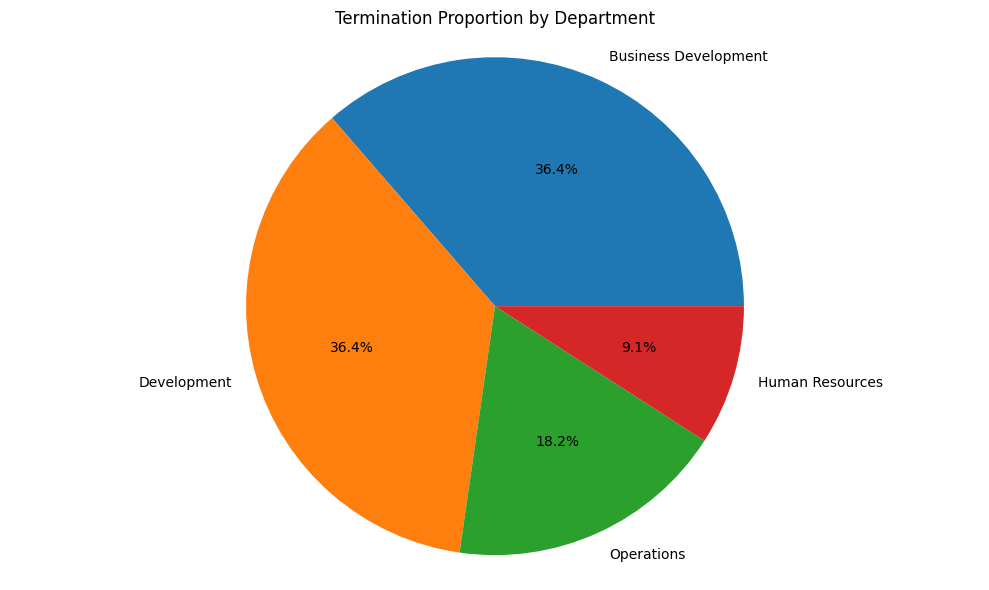

In [9]:
print("Employee Termination Proportion by Department")
# จำนวนคนออกตาม department (รวมทั้งคนที่ออกไปแล้วแลพ predicted ว่าจะออก) == ดูอดีต (และกึ่งอนาคต)

department_count = termination_emp.groupby('department_name')['termination_value'].count().to_frame('termination_count').reset_index()
department_count = department_count.sort_values('termination_count', ascending=False)

# write json result
json_result['termination_proportion_by_department'] = department_count.to_dict(orient='records')

# plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(department_count['termination_count'], labels=department_count['department_name'], autopct='%1.1f%%')
plt.title('Termination Proportion by Department')
plt.axis('equal')
plt.tight_layout()

Employee Termination Proportion by Job Level


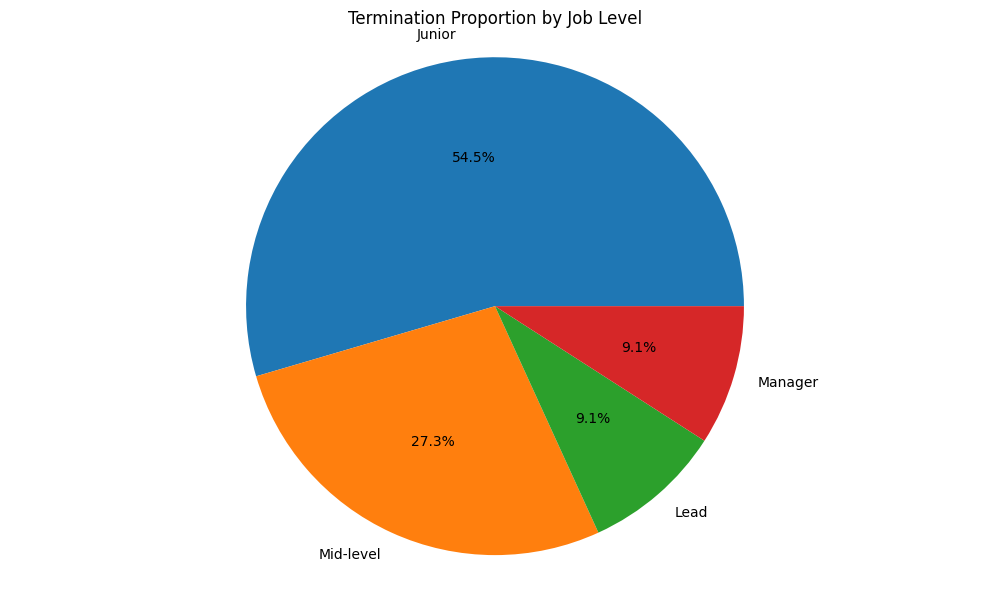

In [10]:
print("Employee Termination Proportion by Job Level")
# จำนวนคนออกตาม job level (รวมทั้งคนที่ออกไปแล้วแลพ predicted ว่าจะออก) == ดูอดีต (และกึ่งอนาคต)


level_count = termination_emp.groupby('job_level')['termination_value'].count().to_frame('termination_count').reset_index()
level_count = level_count.sort_values('termination_count', ascending=False)
level_count['level_name'] = level_count['job_level'].map(config.JOB_LEVEL_MAPPER)

# write json result
json_result['termination_proportion_by_job_level'] = level_count[['level_name', 'termination_count']].to_dict(orient='records')

# plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(level_count['termination_count'], labels=level_count['level_name'], autopct='%1.1f%%')
plt.title('Termination Proportion by Job Level')
plt.axis('equal')
plt.tight_layout()

Average Termination Probability by Department


<Axes: xlabel='department_name', ylabel='model_predicted_termination_probability'>

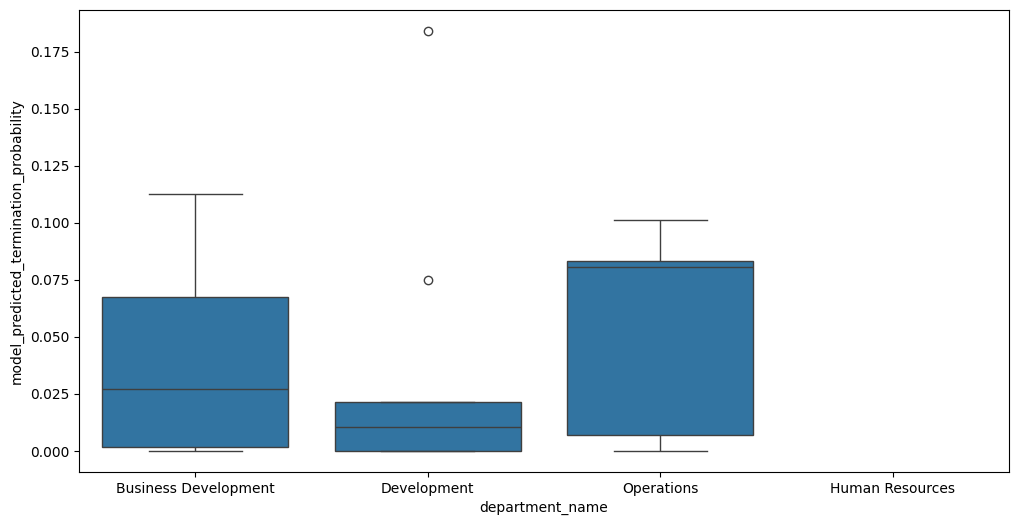

In [11]:
print("Average Termination Probability by Department")
# ค่าเฉลี่ยของ termination probability ตาม department (คาดการณ์อนาคต)
##### จริงๆอยากได้เป็น beeswarm  แต่เหมือน e-chart จะทำไม่ได้

department_prob = employee_metadata.groupby('department_name')['model_predicted_termination_probability'].mean().reset_index()
department_prob.columns = ['department_name', 'average_termination_probability']

# write json result
# json_result['average_termination_probability_by_department'] = department_prob.to_dict(orient='records')

# plot beeswarm plot by department
plt.figure(figsize=(12, 6))
sns.boxplot(data=employee_metadata, x='department_name', y='model_predicted_termination_probability')

Average Termination Probability by Job Level


<Axes: xlabel='job_level_name', ylabel='model_predicted_termination_probability'>

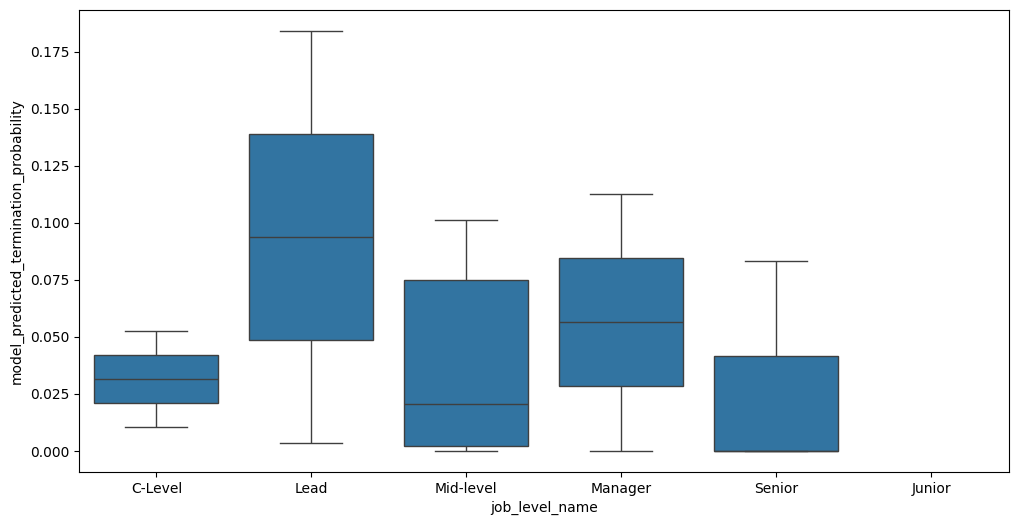

In [12]:
print("Average Termination Probability by Job Level")
# ค่าเฉลี่ยของ termination probability ตาม job level (คาดการณ์อนาคต)
##### จริงๆอยากได้เป็น beeswarm  แต่เหมือน e-chart จะทำไม่ได้

job_level_prob = employee_metadata.groupby('job_level_name')['model_predicted_termination_probability'].mean().reset_index()
job_level_prob.columns = ['job_level', 'average_termination_probability']

# write json result
# json_result['average_termination_probability_by_job_level'] = job_level_prob.to_dict(orient='records')

# plot beeswarm plot by department
plt.figure(figsize=(12, 6))
sns.boxplot(data=employee_metadata, x='job_level_name', y='model_predicted_termination_probability')

Top 5 Reasons Why Empoyees Quit


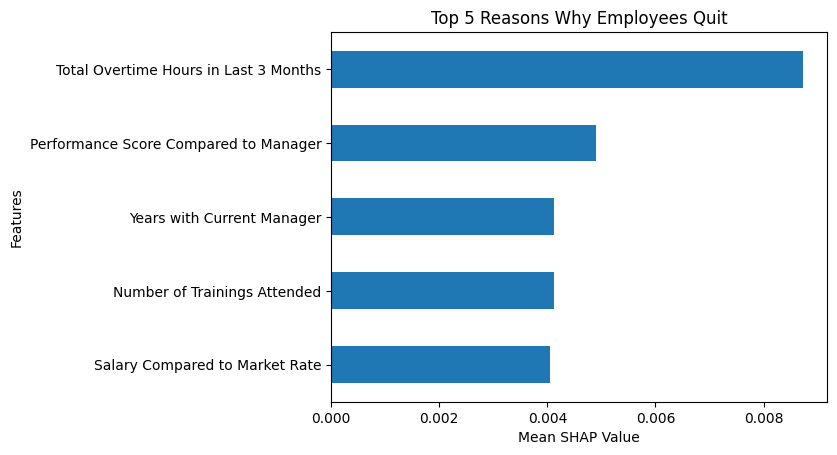

In [13]:
print("Top 5 Reasons Why Empoyees Quit")
# 5 สาเหตุที่พนักงานลาออกมากที่สุด

num_features = 5
mean_importance = (all_shap_df.mean(axis=0, skipna=True).sort_values(ascending=False)).to_frame('impact_value')
mean_importance = mean_importance.drop('emp_id', errors='ignore')
mean_importance = mean_importance.reset_index().rename(columns={'index': 'feature'})
mean_importance = mean_importance.head(num_features)
mean_importance['feature_name'] = mean_importance['feature'].map(config.FEARURES_MEANING_MAPPER)

# write json result
json_result['top_reasons_for_quitting'] = mean_importance[['feature_name', 'impact_value']].to_dict(orient='records')

# plot barh
mean_importance.sort_values(by='impact_value', ascending=True).plot(
    kind='barh', y='impact_value', x='feature_name', legend=False
)
plt.title('Top 5 Reasons Why Employees Quit')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Features')
plt.show()

In [14]:
json_result

{'overall_summary': {'prediction_start_date': '2025-08-31',
  'prediction_end_date': '2025-11-29',
  'total_employees': 18,
  'total_employees_left': 10,
  'employees_predicted_to_leave': 1,
  'average_retention_probability': 0.04184148347277895},
 'termination_proportion_by_department': [{'department_name': 'Business Development',
   'termination_count': 4},
  {'department_name': 'Development', 'termination_count': 4},
  {'department_name': 'Operations', 'termination_count': 2},
  {'department_name': 'Human Resources', 'termination_count': 1}],
 'termination_proportion_by_job_level': [{'level_name': 'Junior',
   'termination_count': 6},
  {'level_name': 'Mid-level', 'termination_count': 3},
  {'level_name': 'Lead', 'termination_count': 1},
  {'level_name': 'Manager', 'termination_count': 1}],
 'top_reasons_for_quitting': [{'feature_name': 'Total Overtime Hours in Last 3 Months',
   'impact_value': 0.00873556642965955},
  {'feature_name': 'Performance Score Compared to Manager',
   'im

#### evaluation by employee

In [44]:
## ยังขาด recommendation tips อยู่

In [15]:
termination_shap_emp = employee_metadata[employee_metadata['model_predicted_termination'] == True].drop_duplicates('emp_id')[['emp_id']]
termination_shap_emp = shap_with_metadata[shap_with_metadata['emp_id'].isin(termination_shap_emp['emp_id'])]
termination_shap_emp['predicted_temination_probability'] = termination_shap_emp['emp_id'].map(model_result.set_index('emp_id')['termination_probability'])
termination_shap_emp

/var/folders/x_/4p1v5h053s7_q_45w6c5prs00000gr/T/ipykernel_64729/3540217691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  termination_shap_emp['predicted_temination_probability'] = termination_shap_emp['emp_id'].map(model_result.set_index('emp_id')['termination_probability'])


,avg_performance_score,age,performance_score_z_manager,year_since_last_salary_adjustment,salary_compare_market_rate,year_with_current_manager,total_working_year_z_job_level,year_in_current_position,performance_score_z_job_level,num_training,...,distance_from_home_to_office,avg_training_per_year,time_since_last_promotion,avg_activity_per_year,total_working_year,emp_id,job_title,job_level_name,department_name,predicted_temination_probability
2,-0.002905,0.001254,0.021921,-0.003807,-0.011216,0.045812,-0.002581,-0.001828,0.003687,0.013391,...,0.009622,-0.007499,-0.000167,-0.001177,0.003584,990003,Team Lead Data Scientist,Lead,Development,0.184187


In [16]:
# write result to JSON
json_topic = "termination_reason_by_employee"
termination_reason_by_employee = {}

for emp_id in termination_shap_emp['emp_id'].unique():
    predicted_termination_probability = termination_shap_emp[termination_shap_emp['emp_id'] == emp_id]['predicted_temination_probability'].values[0]

    _emp_shap_t = termination_shap_emp[termination_shap_emp['emp_id'] == emp_id][features]
    _emp_shap_t = _emp_shap_t.T.reset_index()
    _emp_shap_t.columns = ['feature', 'impact_value']
    abs_mean_shap_value = _emp_shap_t['impact_value'].abs().mean()
    _emp_shap_t = _emp_shap_t[_emp_shap_t['impact_value'].abs() > abs_mean_shap_value]

    _emp_shap_t['feature_name'] = _emp_shap_t['feature'].map(config.FEARURES_MEANING_MAPPER)
    _emp_shap_t.sort_values(by='impact_value', ascending=False, inplace=True)

    # write to JSON
    termination_reason_by_employee[str(emp_id)] = {
        'predicted_termination_probability': predicted_termination_probability,
        'impact_factors': _emp_shap_t[['feature_name', 'impact_value']].to_dict(orient='records')
    }

json_result[json_topic] = termination_reason_by_employee

[990003]


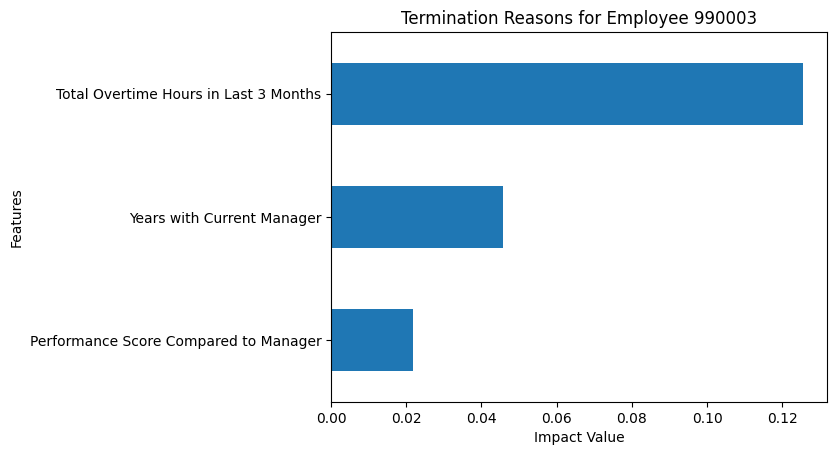

In [17]:
# try sampel plot
print(termination_shap_emp['emp_id'].unique())
sample_emp_id = 990003

# plot barh for sample employee
_temp = termination_reason_by_employee[str(sample_emp_id)]['impact_factors'] 
_temp_df = pd.DataFrame(_temp)
_temp_df.sort_values(by='impact_value', ascending=True).plot(
    kind='barh', y='impact_value', x='feature_name', legend=False
)
plt.title(f'Termination Reasons for Employee {sample_emp_id}')
plt.xlabel('Impact Value')
plt.ylabel('Features')
plt.show()

In [18]:
json_result

{'overall_summary': {'prediction_start_date': '2025-08-31',
  'prediction_end_date': '2025-11-29',
  'total_employees': 18,
  'total_employees_left': 10,
  'employees_predicted_to_leave': 1,
  'average_retention_probability': 0.04184148347277895},
 'termination_proportion_by_department': [{'department_name': 'Business Development',
   'termination_count': 4},
  {'department_name': 'Development', 'termination_count': 4},
  {'department_name': 'Operations', 'termination_count': 2},
  {'department_name': 'Human Resources', 'termination_count': 1}],
 'termination_proportion_by_job_level': [{'level_name': 'Junior',
   'termination_count': 6},
  {'level_name': 'Mid-level', 'termination_count': 3},
  {'level_name': 'Lead', 'termination_count': 1},
  {'level_name': 'Manager', 'termination_count': 1}],
 'top_reasons_for_quitting': [{'feature_name': 'Total Overtime Hours in Last 3 Months',
   'impact_value': 0.00873556642965955},
  {'feature_name': 'Performance Score Compared to Manager',
   'im

##### prev idea analysis

In [49]:
# อันนี้เป็น plot bar สองอันแยก top 5 กับ bottom 5 impact factors สำหรับพนักงานแต่ละคน

In [50]:
print("Termination Result by Employee")
termination_shap_emp = employee_metadata[employee_metadata['model_predicted_termination'] == True].drop_duplicates('emp_id')[['emp_id']]
termination_shap_emp = shap_with_metadata[shap_with_metadata['emp_id'].isin(termination_shap_emp['emp_id'])]
print(termination_shap_emp['emp_id'].to_list())

# get top 5 positive and negative impacts per employee and write into JSON
def get_top_shap(row, top_n=5):
    shap_series = row[features]

    # Sort for positive and negative separately
    top_pos = shap_series.sort_values(ascending=False).head(top_n)
    top_neg = shap_series.sort_values(ascending=True).head(top_n)

    return pd.Series({
        'positive_impact_reasons_to_leave': list(top_pos.index),
        'positive_impact_values': list(top_pos.values),
        'negative_impact_reasons_to_stay': list(top_neg.index),
        'negative_impact_values': list(top_neg.values)
    })

top_features_df = termination_shap_emp.apply(get_top_shap, axis=1)
termination_shap_emp = pd.concat([termination_shap_emp[metadata_columns], top_features_df], axis=1)

# write result into JSON with the key
termination_reason_by_employee = {}
for _, row in termination_shap_emp.iterrows():
    emp_id = row['emp_id']
    positive_reasons = row['positive_impact_reasons_to_leave']
    positive_reasons = [config.FEARURES_MEANING_MAPPER.get(reason, reason) for reason in positive_reasons]
    positive_values = row['positive_impact_values']
    positive_impact = dict(zip(positive_reasons, positive_values))
    termination_reason_by_employee[emp_id] = {"impact_reasons_to_leave": positive_impact}

    negative_reasons = row['negative_impact_reasons_to_stay']
    negative_reasons = [config.FEARURES_MEANING_MAPPER.get(reason, reason) for reason in negative_reasons]
    negative_values = row['negative_impact_values']
    negative_impact = dict(zip(negative_reasons, negative_values))
    termination_reason_by_employee[emp_id]["impact_reasons_to_stay"] = negative_impact

json_result["termination_reason_by_employee"] = termination_reason_by_employee
# Save JSON result to file
with open(f'../output/termination_result.json', 'w') as f:
    json.dump(json_result, f, indent=4)

Termination Result by Employee
[990003, 990021]


In [51]:
positive_reasons

['Total Overtime Hours in Last 3 Months',
 'Average Training Times per Year',
 'Average Activity Times per Year',
 'Salary Compared to Market Rate',
 'Number of Skills Acquired']

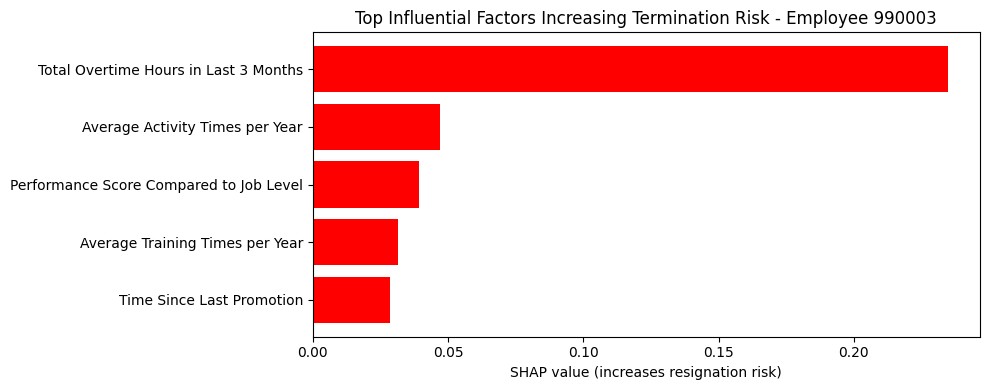

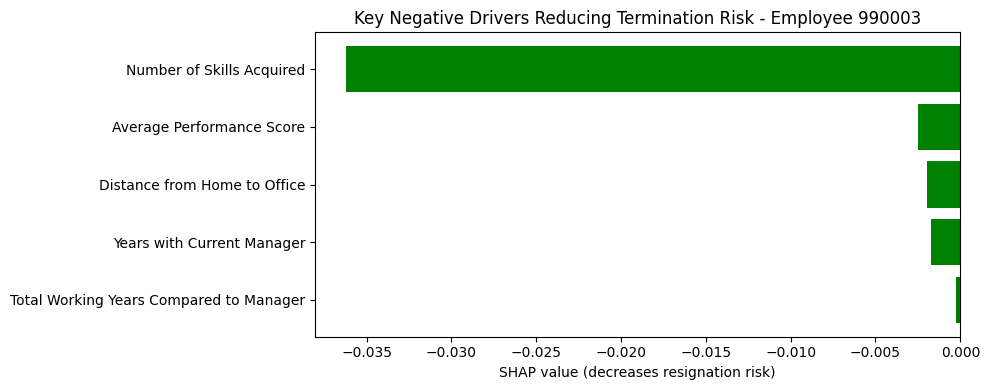

In [52]:
emp_row = termination_shap_emp[termination_shap_emp['emp_id'] == 990003].iloc[0]

pos_df = pd.DataFrame({
    'feature': emp_row['positive_impact_reasons_to_leave'],
    'shap_value': emp_row['positive_impact_values']
})
pos_df['feature_name'] = pos_df['feature'].map(config.FEARURES_MEANING_MAPPER)
neg_df = pd.DataFrame({
    'feature': emp_row['negative_impact_reasons_to_stay'],
    'shap_value': emp_row['negative_impact_values']
})
neg_df['feature_name'] = neg_df['feature'].map(config.FEARURES_MEANING_MAPPER)

# --- Plot positive features ---
plt.figure(figsize=(10,4))
plt.barh(pos_df['feature_name'], pos_df['shap_value'], color='red')
plt.title(f"Top Influential Factors Increasing Termination Risk - Employee {emp_row['emp_id']}")
plt.xlabel("SHAP value (increases resignation risk)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Plot negative features ---
plt.figure(figsize=(10,4))
plt.barh(neg_df['feature_name'], neg_df['shap_value'], color='green')
plt.title(f"Key Negative Drivers Reducing Termination Risk - Employee {emp_row['emp_id']}")
plt.xlabel("SHAP value (decreases resignation risk)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### evaluation by department

In [19]:
# department_name
# number of employee preditcted to leave in xx department
# num emp left in xx department
# average termination probability in xx department
# impact factors
# impact value

department_shap = shap_with_metadata.groupby('department_name')[features].mean().reset_index()
department_shap

,department_name,avg_performance_score,age,performance_score_z_manager,year_since_last_salary_adjustment,salary_compare_market_rate,year_with_current_manager,total_working_year_z_job_level,year_in_current_position,performance_score_z_job_level,num_training,total_working_year_z_manager,num_skills,total_ot_hours_3_months,distance_from_home_to_office,avg_training_per_year,time_since_last_promotion,avg_activity_per_year,total_working_year
0,Business Development,-0.003769,0.000229,0.022602,-0.000122,0.009725,0.006489,0.001032,-0.003197,0.003828,0.000371,-0.003431,-0.000453,-0.008284,-0.002973,0.002070,0.000702,0.000685,0.002512
1,Development,-0.003235,-0.000413,0.000182,-0.000760,0.000842,0.007877,-0.001577,0.000531,0.004035,0.002609,0.004271,-0.000572,0.006996,-0.000142,-0.000235,0.000014,-0.000332,0.001762
2,Operations,-0.000648,-0.001598,-0.000764,-0.004089,0.005305,-0.004509,-0.000460,0.002511,-0.000767,0.009865,0.008775,0.001966,0.025483,-0.001778,0.000715,-0.000751,0.002654,-0.000929


In [20]:
# write to JSON
json_topic = "termination_reason_by_department"
termination_reason_by_department = {}

for department in department_shap['department_name'].unique():
    num_emp_left = termination_emp[termination_emp['department_name'] == department].shape[0]
    num_emp_predicted_to_leave = termination_emp[(termination_emp['department_name'] == department) & (termination_emp['model_predicted_termination'] == True)].shape[0]
    avg_termination_probability = employee_metadata[employee_metadata['department_name'] == department]['model_predicted_termination_probability'].mean()

    _dept_shap_t = department_shap[department_shap['department_name'] == department][features]
    _dept_shap_t = _dept_shap_t.T.reset_index()
    _dept_shap_t.columns = ['feature', 'impact_value']
    abs_mean_shap_value = _dept_shap_t['impact_value'].abs().mean()
    _dept_shap_t = _dept_shap_t[_dept_shap_t['impact_value'].abs() > abs_mean_shap_value]

    _dept_shap_t['feature_name'] = _dept_shap_t['feature'].map(config.FEARURES_MEANING_MAPPER)
    _dept_shap_t.sort_values(by='impact_value', ascending=False, inplace=True)
    display(_dept_shap_t)

    # write to JSON
    termination_reason_by_department[department] = {
        'num_emp_left': num_emp_left,
        'num_emp_predicted_to_leave': num_emp_predicted_to_leave,
        'avg_termination_probability': avg_termination_probability,
        'impact_factors': _dept_shap_t[['feature_name', 'impact_value']].to_dict(orient='records')
    }
json_result[json_topic] = termination_reason_by_department

,feature,impact_value,feature_name
2,performance_score_z_manager,0.022602,Performance Score Compared to Manager
4,salary_compare_market_rate,0.009725,Salary Compared to Market Rate
5,year_with_current_manager,0.006489,Years with Current Manager
12,total_ot_hours_3_months,-0.008284,Total Overtime Hours in Last 3 Months


,feature,impact_value,feature_name
5,year_with_current_manager,0.007877,Years with Current Manager
12,total_ot_hours_3_months,0.006996,Total Overtime Hours in Last 3 Months
10,total_working_year_z_manager,0.004271,Total Working Years Compared to Manager
8,performance_score_z_job_level,0.004035,Performance Score Compared to Job Level
9,num_training,0.002609,Number of Trainings Attended
0,avg_performance_score,-0.003235,Average Performance Score


,feature,impact_value,feature_name
12,total_ot_hours_3_months,0.025483,Total Overtime Hours in Last 3 Months
9,num_training,0.009865,Number of Trainings Attended
10,total_working_year_z_manager,0.008775,Total Working Years Compared to Manager
4,salary_compare_market_rate,0.005305,Salary Compared to Market Rate
3,year_since_last_salary_adjustment,-0.004089,Time Since Last Salary Adjustment
5,year_with_current_manager,-0.004509,Years with Current Manager


['Business Development' 'Development' 'Operations']


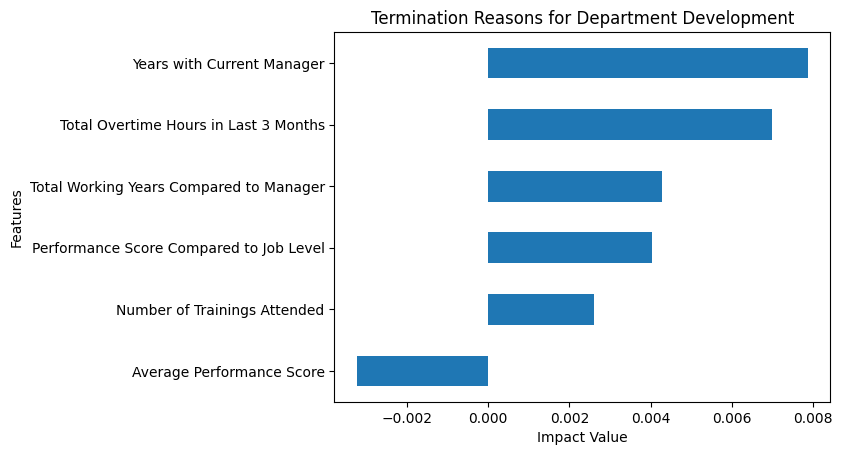

In [21]:
# try sample plot
print(department_shap['department_name'].unique())
sample_department = 'Development'

# plot barh for sample department
_temp = termination_reason_by_department[sample_department]['impact_factors']
_temp_df = pd.DataFrame(_temp)
_temp_df.sort_values(by='impact_value', ascending=True).plot(
    kind='barh', y='impact_value', x='feature_name', legend=False
)
plt.title(f'Termination Reasons for Department {sample_department}')
plt.xlabel('Impact Value')
plt.ylabel('Features')
plt.show()

#### evaluation by job level

In [22]:
# level_name
# number of employee preditcted to leave in xx level
# num emp left in xx level
# average termination probability in xx level
# impact factors
# impact value

job_level_shap = shap_with_metadata.groupby('job_level_name')[features].mean().reset_index()
job_level_shap

,job_level_name,avg_performance_score,age,performance_score_z_manager,year_since_last_salary_adjustment,salary_compare_market_rate,year_with_current_manager,total_working_year_z_job_level,year_in_current_position,performance_score_z_job_level,num_training,total_working_year_z_manager,num_skills,total_ot_hours_3_months,distance_from_home_to_office,avg_training_per_year,time_since_last_promotion,avg_activity_per_year,total_working_year
0,C-Level,-0.001558,-0.000173,0.010375,0.000896,0.017078,0.012492,-0.000628,0.000426,0.003697,0.001654,-0.002203,-0.005236,-0.010021,-0.000641,0.000055,-0.008499,-0.000830,0.002148
1,Lead,-0.004445,0.000640,0.010444,-0.000594,-0.007227,0.025028,0.001596,-0.000816,0.002285,0.006405,-0.005348,-0.004934,0.059052,-0.001641,-0.002994,0.000122,-0.000779,0.004700
2,Manager,-0.001040,0.000324,0.034018,0.001589,-0.002953,0.007401,0.002957,-0.005038,0.001706,0.000178,-0.002805,-0.000158,-0.009130,-0.005541,0.001516,0.016611,-0.001061,0.004431
3,Mid-level,-0.003102,-0.001426,-0.001723,-0.003806,0.005360,-0.002027,-0.001752,0.001564,0.002444,0.004905,0.009674,0.002237,0.008248,-0.000061,0.000619,-0.002157,0.001580,0.000057
4,Senior,-0.001810,0.000153,-0.001979,0.000899,0.003656,0.000901,-0.001482,0.000440,0.003474,0.004559,0.000745,0.001131,0.001067,-0.001956,0.002338,0.000710,0.001382,-0.000602


In [23]:
# write to JSON
json_topic = "termination_reason_by_job_level"
termination_reason_by_job_level = {}

for job_level in job_level_shap['job_level_name'].unique():
    num_emp_left = termination_emp[termination_emp['job_level_name'] == job_level].shape[0]
    num_emp_predicted_to_leave = termination_emp[(termination_emp['job_level_name'] == job_level) & (termination_emp['model_predicted_termination'] == True)].shape[0]
    avg_termination_probability = employee_metadata[employee_metadata['job_level_name'] == job_level]['model_predicted_termination_probability'].mean()

    _level_shap_t = job_level_shap[job_level_shap['job_level_name'] == job_level][features]
    _level_shap_t = _level_shap_t.T.reset_index()
    _level_shap_t.columns = ['feature', 'impact_value']
    abs_mean_shap_value = _level_shap_t['impact_value'].abs().mean()
    _level_shap_t = _level_shap_t[_level_shap_t['impact_value'].abs() > abs_mean_shap_value]

    _level_shap_t['feature_name'] = _level_shap_t['feature'].map(config.FEARURES_MEANING_MAPPER)
    _level_shap_t.sort_values(by='impact_value', ascending=False, inplace=True)
    display(_level_shap_t)
    
    # write to JSON
    termination_reason_by_job_level[job_level] = {
        'num_emp_left': num_emp_left,
        'num_emp_predicted_to_leave': num_emp_predicted_to_leave,
        'avg_termination_probability': avg_termination_probability,
        'impact_factors': _level_shap_t[['feature_name', 'impact_value']].to_dict(orient='records')
    }
json_result[json_topic] = termination_reason_by_job_level

,feature,impact_value,feature_name
4,salary_compare_market_rate,0.017078,Salary Compared to Market Rate
5,year_with_current_manager,0.012492,Years with Current Manager
2,performance_score_z_manager,0.010375,Performance Score Compared to Manager
11,num_skills,-0.005236,Number of Skills Acquired
15,time_since_last_promotion,-0.008499,Time Since Last Promotion
12,total_ot_hours_3_months,-0.010021,Total Overtime Hours in Last 3 Months


,feature,impact_value,feature_name
12,total_ot_hours_3_months,0.059052,Total Overtime Hours in Last 3 Months
5,year_with_current_manager,0.025028,Years with Current Manager
2,performance_score_z_manager,0.010444,Performance Score Compared to Manager


,feature,impact_value,feature_name
2,performance_score_z_manager,0.034018,Performance Score Compared to Manager
15,time_since_last_promotion,0.016611,Time Since Last Promotion
5,year_with_current_manager,0.007401,Years with Current Manager
13,distance_from_home_to_office,-0.005541,Distance from Home to Office
12,total_ot_hours_3_months,-0.009130,Total Overtime Hours in Last 3 Months


,feature,impact_value,feature_name
10,total_working_year_z_manager,0.009674,Total Working Years Compared to Manager
12,total_ot_hours_3_months,0.008248,Total Overtime Hours in Last 3 Months
4,salary_compare_market_rate,0.005360,Salary Compared to Market Rate
9,num_training,0.004905,Number of Trainings Attended
0,avg_performance_score,-0.003102,Average Performance Score
3,year_since_last_salary_adjustment,-0.003806,Time Since Last Salary Adjustment


,feature,impact_value,feature_name
9,num_training,0.004559,Number of Trainings Attended
4,salary_compare_market_rate,0.003656,Salary Compared to Market Rate
8,performance_score_z_job_level,0.003474,Performance Score Compared to Job Level
14,avg_training_per_year,0.002338,Average Training Times per Year
0,avg_performance_score,-0.001810,Average Performance Score
13,distance_from_home_to_office,-0.001956,Distance from Home to Office
2,performance_score_z_manager,-0.001979,Performance Score Compared to Manager


['C-Level' 'Lead' 'Manager' 'Mid-level' 'Senior']


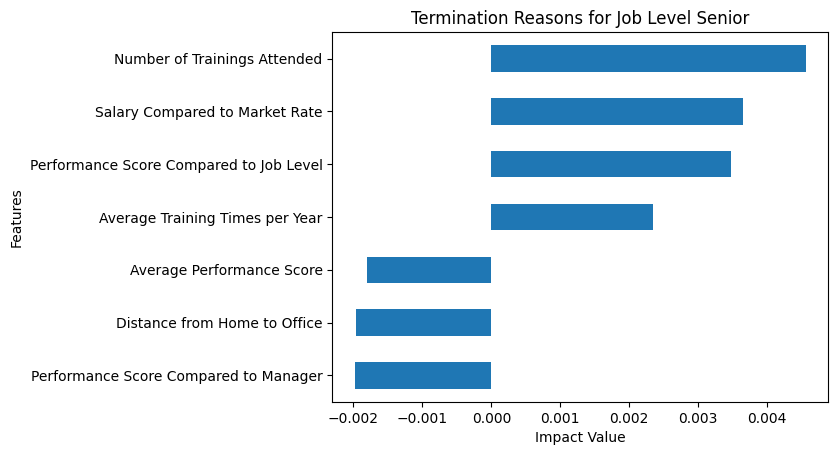

In [24]:
# try sample plot
print(job_level_shap['job_level_name'].unique())
sample_job_level = 'Senior'

# plot barh for sample job level
_temp = termination_reason_by_job_level[sample_job_level]['impact_factors']
_temp_df = pd.DataFrame(_temp)
_temp_df.sort_values(by='impact_value', ascending=True).plot(
    kind='barh', y='impact_value', x='feature_name', legend=False
)
plt.title(f'Termination Reasons for Job Level {sample_job_level}')
plt.xlabel('Impact Value')
plt.ylabel('Features')
plt.show()

#### save final JSON

In [25]:
json_result

{'overall_summary': {'prediction_start_date': '2025-08-31',
  'prediction_end_date': '2025-11-29',
  'total_employees': 18,
  'total_employees_left': 10,
  'employees_predicted_to_leave': 1,
  'average_retention_probability': 0.04184148347277895},
 'termination_proportion_by_department': [{'department_name': 'Business Development',
   'termination_count': 4},
  {'department_name': 'Development', 'termination_count': 4},
  {'department_name': 'Operations', 'termination_count': 2},
  {'department_name': 'Human Resources', 'termination_count': 1}],
 'termination_proportion_by_job_level': [{'level_name': 'Junior',
   'termination_count': 6},
  {'level_name': 'Mid-level', 'termination_count': 3},
  {'level_name': 'Lead', 'termination_count': 1},
  {'level_name': 'Manager', 'termination_count': 1}],
 'top_reasons_for_quitting': [{'feature_name': 'Total Overtime Hours in Last 3 Months',
   'impact_value': 0.00873556642965955},
  {'feature_name': 'Performance Score Compared to Manager',
   'im

In [26]:
# save json result to file
with open(f'../{config.TERMINATION_RESULT_JSON_PATH}', 'w') as f:
    json.dump(json_result, f, indent=4)